# Preface

This notebook goes over a method for clustering high dimensional data onto a two dimensional plane. I was frustrated at the resolution of SOM clustering.

# Problem Definition

Suppose that we have data $Z=\{z_1, ..., z_N\}$, $z_i \in \mathbb{R}^D$ that we wish to project on to some 2-dimensional grid $G$. Each $z_i$ is mapped to a coordinate in $G$ via $g(z_i) \mapsto x_i \in G$. Suppose further that the $z_i$ have some symmetric distance function $d_1(z_i, z_j) \mapsto \mathbb{R}$, and the $x_i$ have the euclidean distance function $d_2$. Let $\Sigma = \bigcup_{i=1}^N \bigcup_{j = i + 1}^N \{(z_i, z_j)\}$, i.e. the set of all 2-combination tuples of $Z$; and, $
\star$ denote [function mapping](https://reference.wolfram.com/language/howto/MapAFunctionOverAList.html).

The goal is to maximize the correlation between sets $D_1 = d_1 \star \Sigma$ and $D_2 = d_2 \star \Sigma$. That is, we wish to make points that are close in the high-dimensional space (according to $d_1$) also be close on the grid (according to $d_2$), and same for far-away points. For now, we want to achieve maximum linear correlation and not something quadratic. If we would aim for the latter, then we would be exagerating distances in the high-dimensional space on the grid (which might be better, but we disregard it for simplicity's sake now). 

The correlation between two sets $A = \{a_i\}$ and $B = \{b_i\}$ is $$r_{AB} = \frac{\sum_{i}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_i(a_i - \bar{a})^2 \sum_i(b_i - \bar{b})^2}} $$
and in our case it could be that $A = D_1$ and $B = D_2$. We wish to optimize this $r_{D_1D_2}$ over the variables $d_2 \star \Sigma$ which are dependent on the coordinates $g \star Z$. There would probably also be coordinate constraints, such as the size of the grid, which would further confound the problem. But as it stands, we simply need to maximize this function 

One idea initially comes to mind on how to solve this problem: initialize a random assignment to each $z_i$ within the constraints of the grid. Call this assignment $g$. We can then use a genetic algorithm whose initial population is a random collection of different $g_i$. The fitness function is then simply the correlation cofficient, and we wish to maximize this coefficient. I will experiment with that now.

# Sovling with a Genetic Algorithm

There exists several very good genetic algorithm libaries for Python, notably `deap`. For some reason Python 3 isn't working properly on Wakari.io, so instead I'll just be using Python 2. Bleh. I'll start off by experimenting with clustering colors, which are just 3-dimensional vectors (our high-dimesnional vectors). So, to do that let's generate our set $Z$.

And note that for the following code, I took inspiration from these sources:
- [OneMax Problem](http://nbviewer.ipython.org/github/DEAP/notebooks/blob/master/OneMax.ipynb)
- [Using genetic algorithms to solve the traveling salesperson problem](http://nbviewer.ipython.org/github/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb)
- [Color Difference between 2 colors using Python](http://snapower-opencv.tumblr.com/post/101669832648/color-difference-between-2-colors-using-python)

### Defining >2-dimensional vectors

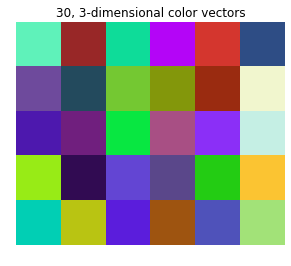

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

NCOLORS = 30

np.random.seed(42)
colors = np.random.rand(1, NCOLORS, 3)    # 16 RGB vectors

# and here's a quick hack to factor NCOLORs into a quasi-square product of two numbers
x = int(NCOLORS**0.5)
while NCOLORS % x != 0:
    x -= 1
y = NCOLORS//x

plt.imshow(colors.reshape(x, y, 3), interpolation='nearest')
plt.axis('off')
plt.title('{}, 3-dimensional color vectors'.format(NCOLORS))
plt.show()

What distance between colors should we use? Apparently there's a long history on this topic, see the [Wikipedia article](http://en.wikipedia.org/wiki/Color_difference) and this cool post on [SNA Power Computer Vision](http://snapower-opencv.tumblr.com/post/101669832648/color-difference-between-2-colors-using-python). So I've installed the package `colormath` to take care of this, and I borrow code ideas from that latter post.

In [4]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

def rgb_diff(rgb1, rgb2):
    c1_rgb, c2_rgb = sRGBColor(*rgb1), sRGBColor(*rgb2)
    c1_lab, c2_lab = convert_color(c1_rgb, LabColor), convert_color(c2_rgb, LabColor)
    return delta_e_cie2000(c1_lab, c2_lab)

With $d_1$ we can now start to define our fitness functionm, which I'll call `corr`. Each individual in the population will be a list of coordinates on $G$. Remember that we want to maximize the correlation between all (symmetric) pairs of distances, between $d_1 \star \Sigma$ and $d_2 \star \Sigma$. Luckily Python's `itertools` package has a function `combinations()` that always spits out combinations in lexicographic order. So we can precompute those distances $d_1 \star \Sigma$:

In [5]:
colors.shape

(1, 30, 3)

In [6]:
from itertools import combinations, chain

z_distances = [rgb_diff(c1, c2) for c1, c2 in combinations(map(list, chain(*colors)), 2)]

With that we can define `corr()`, our fitness function:

In [7]:
from scipy.spatial.distance import euclidean

def corr(X):    # each individual is the list of coordinates X
    x_distances = [euclidean(x1, x2) for x1, x2 in combinations(X, 2)]
    return np.corrcoef(x_distances, z_distances)[0, 1],

### Evolving a population of random coordinates

In [8]:
from deap import base, creator, tools, algorithms

ImportError: No module named 'deap'

In [ ]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

Each individual in a population is list of coordinates in our grid. For sake of simplicity let our grid be square and follow the bounds $0 \le x, y < 1$.

In [ ]:
toolbox = base.Toolbox()
toolbox.register('coordinate', lambda: tuple(np.random.random(2)))
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.coordinate, n=NCOLORS)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [ ]:
def mutate(individual, indpb):
    for i in range(len(individual)):
        if np.random.random() < indpb:
            individual[i] = toolbox.coordinate()
    return individual,

In [ ]:
toolbox.register('evaluate', corr)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', mutate, indpb=0.5)
toolbox.register('select', tools.selTournament, tournsize=3)

And before we run the population, we're going to define some statistics that will be useful for seeing how the population evolved. Namely, the average and max fitness, and the highest fit individual for each generation. Aaand a simple multiprocessor for parallel evaluation.

In [ ]:
stats = tools.Statistics()
stats.register('avg_fit', lambda pop: np.mean([ind.fitness.values[0] for ind in pop]))
stats.register('max_fit', lambda pop: max(ind.fitness.values[0] for ind in pop))
stats.register('winner', lambda pop: max(pop, key=lambda ind: ind.fitness.values[0]))

In [ ]:
import multiprocessing

pool = multiprocessing.Pool()
toolbox.register('map', pool.map)

In [ ]:
%%time
result, log = algorithms.eaSimple(toolbox.population(n=2000), toolbox,
                             cxpb=0.6, mutpb=0.2,
                             ngen=60, verbose=False,
                             stats=stats)

Now, to visualize an individual we need a function that plots the colors at the individuals coordinates. That is, each individual is some mapping $g$, and we need a function to see that $g$ in action.

In [ ]:
def plot_individual(ind):
    for i, (x, y) in enumerate(ind):
        plt.scatter(x, y, c=colors[0, i, :], s=200, lw=0)
    plt.title('Fitness of individual: {}'.format(round(corr(ind)[0], 3)))
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.show()

In [ ]:
best_individual = tools.selBest(result, k=1)[0]
plot_individual(best_individual)

And now to plot the fitness over the course of its evolution.

In [ ]:
plt.plot(log.select('max_fit'),'c-', log.select('avg_fit'), 'b-', antialiased=True)
plt.title('Population fitness over time')
plt.legend(('min fitness', 'mean fitness'), loc='lower right')
plt.ylabel('corr fitness')
plt.xlabel('generation')
plt.show()

### Visualizing the evolution

Just to be cool like [Luis Martí](http://nbviewer.ipython.org/github/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb), let's create some visualizations for our genetic algorithm's progress by using `matplotlib` animations. To do this, we'll need to record the population as it evolves. 

In [ ]:
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig, ax = plt.subplots()
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])
sc = ax.scatter([], [], c=colors[0, :, :], s=200, lw=0)

def animate(i):
    winner = log[i]['winner']
    sc.set_offsets(np.array(winner))
    return sc,

animation.FuncAnimation(fig, animate, frames=60)

### Discussion

That's a pretty good result. And note that this was done pretty naively: not much thought was put into the mutation rate, or crossover.